In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread
import matplotlib.ticker as mtick
import seaborn as sns
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.manifold import TSNE
import warnings
warnings.filterwarnings('ignore')

# Parameters

In [2]:
np.random.seed(2021)    # reset random number generator for reproducibility

n_train = 10
n_test = 100

n_pc = 40

save_fig = True

# Load textures

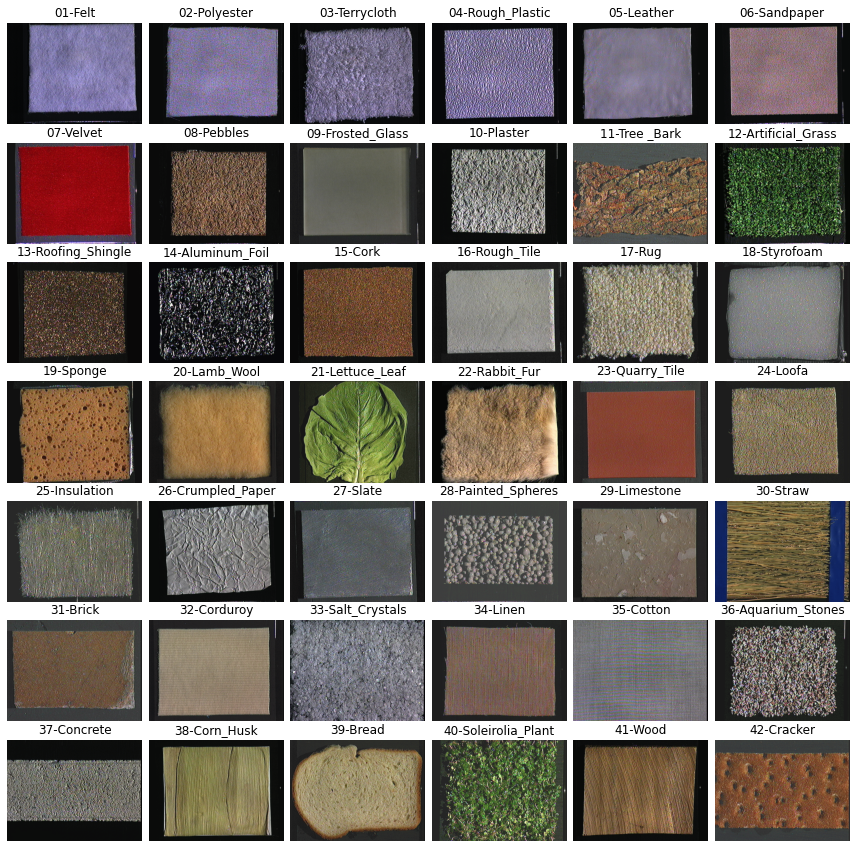

In [3]:
files = os.listdir("./texture")
textures_full = [imread("texture/" + file) for file in files]
textures = [imread("texture/" + file)[120:360, 160:480, :3] for file in files]

# figure: all_textures
if save_fig:
    fig = plt.figure(figsize=(12, 12))
    for i in range(len(textures_full)):
        fig.add_subplot(7, 6, i+1)
        plt.imshow(textures_full[i])
        plt.axis('off')
        plt.title(files[i][:-4])
    fig.tight_layout()
    fig.subplots_adjust(wspace=0.05, hspace=0.05)
    fig.savefig("fig/all_textures.pdf", dpi=300, bbox_inches='tight')

# Sample images

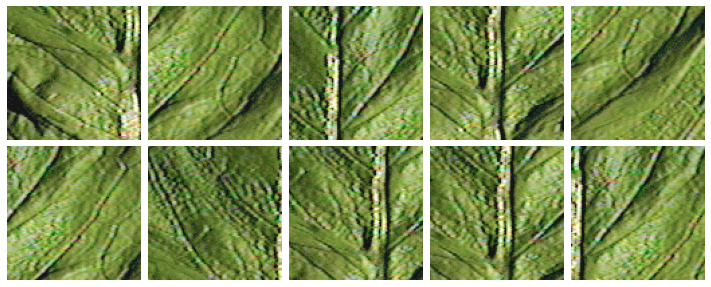

In [4]:
def generate_data(n):
    images = np.zeros([len(textures)*n, 100, 100, 3], dtype=float)
    classes = np.zeros(len(textures)*n, dtype=int)
    for i in range(len(textures)):
        for j in range(n):
            x0 = np.random.randint(140)
            y0 = np.random.randint(220)
            images[i*n+j] = textures[i][x0:x0+100, y0:y0+100, :3] / 256
            classes[i*n+j] = i
    return images, classes

def shuffle(images, classes):
    index = list(range(len(classes)))
    np.random.shuffle(index)
    images = images[index]
    classes = classes[index]
    return images, classes

images_test, classes_test = generate_data(n_test)
images_test, classes_test = shuffle(images_test, classes_test)

images_train, classes_train = generate_data(n_train)

# figure: lettuce_samples
if save_fig:
    fig = plt.figure(figsize=(10, 4.1))
    for j in range(n_train):
        fig.add_subplot(2, 5, j+1)
        plt.imshow(images_train[20*n_train+j])
        plt.axis('off')
    fig.tight_layout()
    fig.subplots_adjust(wspace=0.05, hspace=0.05)
    fig.savefig(f"fig/lettuce_samples_{n_train}.pdf", dpi=300, bbox_inches='tight')

images_train, classes_train = shuffle(images_train, classes_train)

# Feature engineering: signatures

In [5]:
def diff(X):    # X is a square matrix
    dx = 1 / (X.shape[0] - 1)
    mixed_dX = (X[1:, 1:] - X[:-1, 1:] - X[1:, :-1] + X[:-1, :-1]) / (dx * dx)
    dXdu = (X[1:, :] - X[:-1, :]) / dx
    dXdu = (dXdu[:, :-1] + dXdu[:, 1:]) / 2
    dXdv = (X[:, 1:] - X[:, :-1]) / dx
    dXdv = (dXdv[:-1, :] + dXdv[1:, :]) / 2
    mul_dX = dXdu * dXdv
    return mixed_dX, mul_dX, dx

def integrate(X):
    dx = 1 / (X.shape[0] - 1)
    return np.cumsum(np.cumsum(X, axis=0), axis=1) * (dx * dx)

def signatures(X):
    mixed_dX, mul_dX, dx = diff(X)
    return np.array([np.sum(integrate(mixed_dX) * mixed_dX) * (dx * dx),
                     np.sum(integrate(mixed_dX) * mul_dX) * (dx * dx),
                     np.sum(integrate(mul_dX) * mixed_dX) * (dx * dx),
                     np.sum(integrate(mul_dX) * mul_dX) * (dx * dx)])

def calculate_signatures(image):
    return np.hstack([signatures(image[:,:,0]), signatures(image[:,:,1]), signatures(image[:,:,2])])

def calculate_signatures_sym(image):
    return np.mean(np.vstack([calculate_signatures(image),
                              calculate_signatures(np.rot90(image,1)),
                              calculate_signatures(np.rot90(image,2)),
                              calculate_signatures(np.rot90(image,3)),
                              calculate_signatures(np.fliplr(image)),
                              calculate_signatures(np.rot90(np.fliplr(image),1)),
                              calculate_signatures(np.rot90(np.fliplr(image),2)),
                              calculate_signatures(np.rot90(np.fliplr(image),3))]), axis=0)

# Project data into feature space

In [6]:
# signature features
f_sig_train = np.array([calculate_signatures(image) for image in images_train])
f_sig_test = np.array([calculate_signatures(image) for image in images_test])

f_sig_sym_train = np.array([calculate_signatures_sym(image) for image in images_train])
f_sig_sym_test = np.array([calculate_signatures_sym(image) for image in images_test])

# PCA features
pca = PCA(n_components=n_pc)
pca.fit(images_train.reshape(images_train.shape[0], -1))

f_pca_train = pca.transform(images_train.reshape(images_train.shape[0], -1))
f_pca_test = pca.transform(images_test.reshape(images_test.shape[0], -1))

# Explained variance of PCA

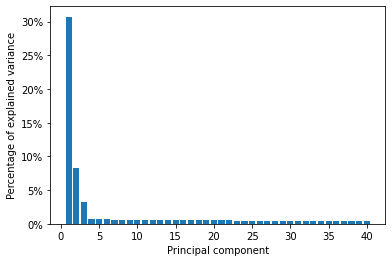

In [7]:
if save_fig:
    plt.figure(figsize=(6,4))
    plt.bar(np.arange(1,n_pc+1), pca.explained_variance_ratio_)
    plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1,decimals=0))
    plt.xlabel("Principal component")
    plt.ylabel("Percentage of explained variance")
    plt.savefig(f"fig/PCA_{n_train}.pdf", dpi=300, bbox_inches='tight')

# T-SNE

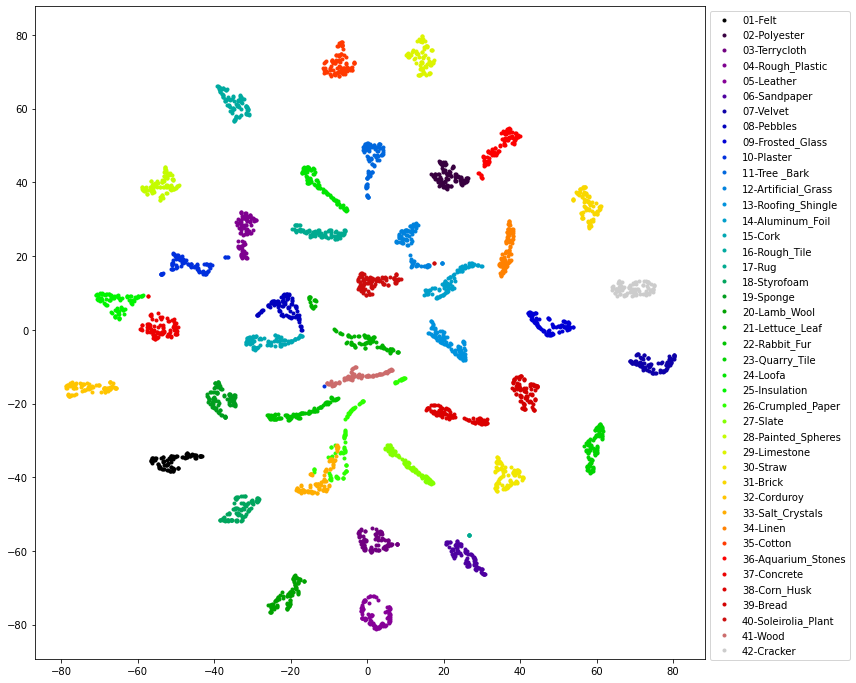

In [8]:
if save_fig:
    f_embedded_test = TSNE(n_components=2, learning_rate='auto', metric="l1", init='random', random_state=2022
        ).fit_transform(np.hstack([f_sig_sym_test, f_pca_test[:,:3]]))
    
    plt.figure(figsize=[12,12])
    colormap = plt.cm.nipy_spectral
    colors = [colormap(i) for i in np.linspace(0, 1, 42)]
    plt.gca().set_prop_cycle('color', colors)
    for i in range(42):
        plt.plot(f_embedded_test[classes_test==i,0], f_embedded_test[classes_test==i,1], '.', label=files[i][:-4])
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.savefig(f"fig/TSNE_{n_train}.pdf", dpi=300, bbox_inches='tight')

# Train and Test

In [9]:
models = [[None for j in range(n_pc+1)] for i in range(3)]
accuracies = np.zeros([3, n_pc+1])
accuracies[0,0] = 1 / 42

for j in range(1, n_pc+1):
    models[0][j] = RandomForestClassifier(random_state=2022)
    models[0][j].fit(f_pca_train[:,:j], classes_train)
    accuracies[0,j] = np.mean(models[0][j].predict(f_pca_test[:,:j])==classes_test)

In [10]:
for j in range(n_pc+1):
    models[1][j] = RandomForestClassifier(random_state=2022)
    models[1][j].fit(np.hstack([f_sig_train, f_pca_train[:,:j]]), classes_train)
    accuracies[1,j] = np.mean(models[1][j].predict(np.hstack([f_sig_test, f_pca_test[:,:j]]))==classes_test)

In [11]:
for j in range(n_pc+1):
    models[2][j] = RandomForestClassifier(random_state=2022)
    models[2][j].fit(np.hstack([f_sig_sym_train, f_pca_train[:,:j]]), classes_train)
    accuracies[2,j] = np.mean(models[2][j].predict(np.hstack([f_sig_sym_test, f_pca_test[:,:j]]))==classes_test)

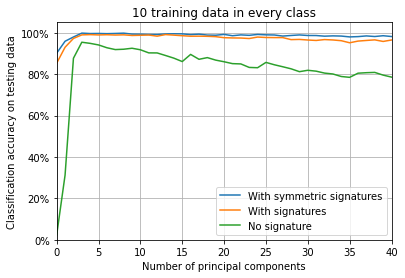

In [12]:
if save_fig:
    plt.figure(figsize=(6,4))
    plt.plot(np.arange(n_pc+1), accuracies[2,:], label="With symmetric signatures")
    plt.plot(np.arange(n_pc+1), accuracies[1,:], label="With signatures")
    plt.plot(np.arange(n_pc+1), accuracies[0,:], label="No signature")
    plt.legend()
    plt.xlim(0,40)
    plt.ylim(0,1.05)
    plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1,decimals=0))
    plt.xlabel("Number of principal components")
    plt.ylabel("Classification accuracy on testing data")
    plt.title(f"{n_train} training data in every class")
    plt.grid()
    plt.savefig(f"fig/accuracy_{n_train}.pdf", dpi=300, bbox_inches='tight')